# Прогнозирование индекса промышленного производства

Для предсказания изменений в индексе промышленного производства применяется методика градиентного бустинга с использованием библиотеки CatBoost

### Определяющие признаки:
- Новостной индекс ЦБ (news)
- Индекс цен на электроэнергию в первой ценовой зоне (consumer_price)
- Промышленность (cb_monitor)
- Индикатор бизнес климата (bussines_clim)
- Курс рубля (curs)
- Погрузка на сети РЖД (rzd)

Каждый признак имеет разный лаг эффекта на экономику. Поэтому для различных прогнозов будут созданы столбцы с лагами __(с постфиксом lag_i)__ Более того, при прогнозе более чем на месяц, новостной индекс ЦБ имеет все большую предсказательную силу

Для каждого из трех прогнозируемых периодов обучается отдельная модель, поскольку лаг-переменные, отражающие временные сдвиги в воздействии факторов, фактически представляют собой новые признаки

## Импорт библиотек и установка зависимостей

In [1]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/pycups-2.0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/PyPDF3-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [3]:
import pandas as pd
import datetime
import numpy as np

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Импорт данных

In [4]:
df = pd.read_csv('../data/preprocessed_ipp_factors.csv', index_col='Unnamed: 0')

df.date = pd.to_datetime(df.date).dt.date

In [5]:
df.head(3)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,interest_rate
0,2015-01-31,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,15.380952
1,2015-02-28,99.8,-1.756337,1156.01,-11.936877,2.572276,64.518174,92.5,13.789474
2,2015-03-31,101.9,-1.972270,1167.50,-7.194668,6.963493,60.363090,103.0,13.409091


# Добавление столбцов с лаггом

### Лаги для признаков:
- __Новостной индекс ЦБ (news):__ 1 месяц
- __Индекс цен на электроэнергию в первой ценовой зоне (consumer_price):__ 0 месяцев
- __Промышленность (cb_monitor):__ 2 месяца
- __Индикатор бизнес климата (bussines_clim):__ 2 месяца
- __Курс рубля (curs):__ 0 месяцев
- __Погрузка на сети РЖД (rzd):__ 1 месяц
- __Среднемесячная ключевая ставка ЦБ (interest_rate)__: 

In [6]:
df.head(1)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,interest_rate
0,2015-01-31,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,15.380952


In [7]:
for i in range(1, 6 + 1):
    df[f'goal_lag_{i}'] = df['goal'].shift(i) ** 2
    df[f'news_lag_{i}'] = df['news'].shift(i)
    df[f'bussines_clim_lag_{i}'] = df['bussines_clim'].shift(i)
    df[f'cb_monitor_lag_{i}'] = df['cb_monitor'].shift(i)
    df[f'rzd_lag_{i}'] = df['rzd'].shift(i)
    df[f'consumer_price_lag_{i}'] = df['consumer_price'].shift(i)
    df[f'interest_rate_lag_{i + 3}'] = df['interest_rate'].shift(i)
    df[f'curs_lag_{i}'] = df['curs'].shift(i)

df = df.fillna(method='pad')

In [8]:
df.columns

Index(['date', 'goal', 'news', 'consumer_price', 'cb_monitor', 'bussines_clim',
       'curs', 'rzd', 'interest_rate', 'goal_lag_1', 'news_lag_1',
       'bussines_clim_lag_1', 'cb_monitor_lag_1', 'rzd_lag_1',
       'consumer_price_lag_1', 'interest_rate_lag_4', 'curs_lag_1',
       'goal_lag_2', 'news_lag_2', 'bussines_clim_lag_2', 'cb_monitor_lag_2',
       'rzd_lag_2', 'consumer_price_lag_2', 'interest_rate_lag_5',
       'curs_lag_2', 'goal_lag_3', 'news_lag_3', 'bussines_clim_lag_3',
       'cb_monitor_lag_3', 'rzd_lag_3', 'consumer_price_lag_3',
       'interest_rate_lag_6', 'curs_lag_3', 'goal_lag_4', 'news_lag_4',
       'bussines_clim_lag_4', 'cb_monitor_lag_4', 'rzd_lag_4',
       'consumer_price_lag_4', 'interest_rate_lag_7', 'curs_lag_4',
       'goal_lag_5', 'news_lag_5', 'bussines_clim_lag_5', 'cb_monitor_lag_5',
       'rzd_lag_5', 'consumer_price_lag_5', 'interest_rate_lag_8',
       'curs_lag_5', 'goal_lag_6', 'news_lag_6', 'bussines_clim_lag_6',
       'cb_monitor_la

In [9]:
df.head(3)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,interest_rate,goal_lag_1,...,interest_rate_lag_8,curs_lag_5,goal_lag_6,news_lag_6,bussines_clim_lag_6,cb_monitor_lag_6,rzd_lag_6,consumer_price_lag_6,interest_rate_lag_9,curs_lag_6
0,2015-01-31,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,15.380952,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-28,99.8,-1.756337,1156.01,-11.936877,2.572276,64.518174,92.5,13.789474,10261.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-03-31,101.9,-1.972270,1167.50,-7.194668,6.963493,60.363090,103.0,13.409091,9960.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Стационарность ряда

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

In [9]:
adfuller(df.goal)

(-2.590156990581484,
 0.09504873012091847,
 13,
 94,
 {'1%': -3.5019123847798657,
  '5%': -2.892815255482889,
  '10%': -2.583453861475781},
 403.9761667346637)

In [10]:
result = adfuller(df.goal)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

print(f'Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -2.590156990581484
p-value: 0.09504873012091847
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583


In [65]:
result = kpss(df.goal, nlags=12)

print(f'p-value: {result[0]}')
print(f'Critical Values:')
for key, value in result[3].items():
    print(f'\t{key}: {value:.3f}')

p-value: 0.07129276944008818
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/tmp/ipykernel_2423/4210407378.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df.goal, nlags=12)


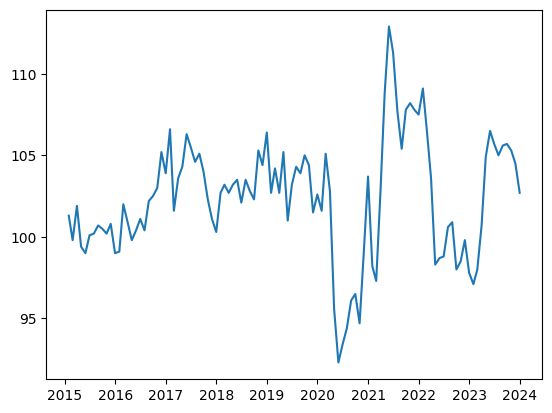

In [11]:
plt.plot(df.date, df.goal)

Дисперсия растет со временем

# Ключевая ставка

В зависимости от лага (6-9 месяцев) или 2 года меняется коэффициент корреляции между 

Связь ИПП и ключевой ставки очевидно отрицательна, но дальнейший рост видимо вызван именно правильной политикой ЦБ, которая и приводит к росту промышленности после антикризисных мер

(-1.0, 1.0)

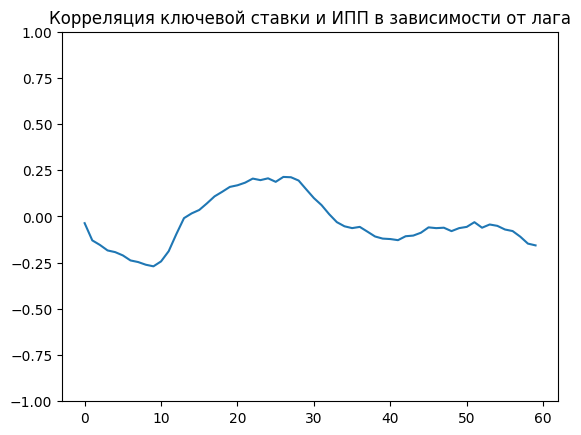

In [49]:
plt.title('Корреляция ключевой ставки и ИПП в зависимости от лага')

plt.plot(range(60), [df['interest_rate'].shift(i).corr(df.goal) for i in range(60)])
plt.ylim([-1, 1])

In [50]:
# Лаг в 9 месяцев
df['interest_rate']\
    .shift(9)\
    .corr(df.goal)

-0.26975355896241526

In [51]:
# Лаг в 2 года
df['interest_rate']\
    .shift(24)\
    .corr(df.goal)

0.20642284164738492

## Корреляция ИПП с признаками (с лаггом)

экзогенные переменные для прогнозирования на 1 месяц вперед

In [11]:
exog_var = ['news_lag_1', 'consumer_price', 'cb_monitor_lag_2', 'bussines_clim_lag_1', 'curs', 'rzd_lag_1', 'interest_rate_lag_6']

<Axes: >

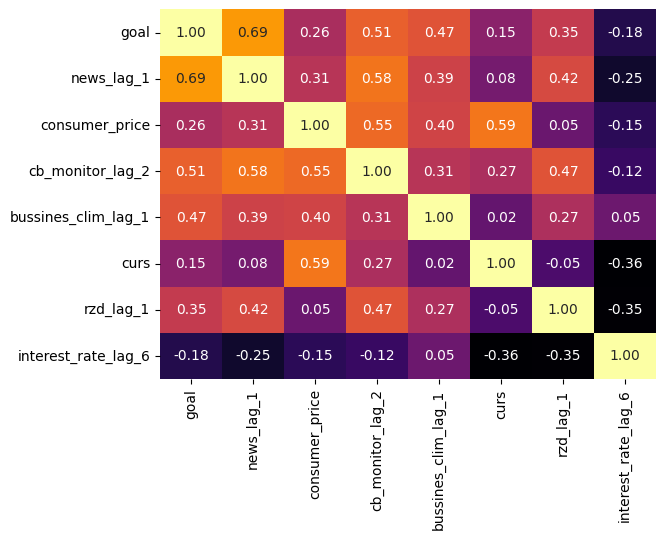

In [12]:
sns.heatmap(
    df[['goal'] + exog_var].corr(),
    fmt=".2f",
    # ax=ax,
    annot=True,
    cmap='inferno',
    cbar=False
)

Заметим, что cb_monitor и bussines_clim сильно коррелируемы: попробуем с помощью метода главных компонентов выделить главную компоненту

# Определим порядок признаков для модели CatBoost

Порядок признаков важен для модели, сортировать их по корреляции не очень правильно, поэтому экономически обоснуем их порядок

1. Первым пойдет новостной индекс, поскольку на производство достаточно сильно влияют настроения в обществе и этот индекс лучше всего это отражает
2. Далее, идут индексы для бизнеса в россии
3. Потом ключевая ставка
4. Потом поставки РЖД
5. В конце курс, потому что производство в РФ все меньше зависит от импорта и курса валют

In [13]:
exog_var = [
    'goal_lag_1',
    'goal_lag_2',
    'news_lag_1',
    'news_lag_2',
    'news_lag_3',
    'cb_monitor_lag_2',
    'bussines_clim_lag_1',
    'rzd_lag_1',
    'interest_rate_lag_4',
    'consumer_price',
    'curs',
]

# Сделаем прогноз на 1 месяц

Для этого обучим модель по следующим признакам:

Поделим на обучающую и тестовую выборку 80/20

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df[exog_var], df.goal, test_size = 0.2, random_state = 42,shuffle=False)

model_1 = CatBoostRegressor(verbose=False, loss_function='RMSE')

grid = {
    'iterations':    [6, 8, 16, 32], 
    'depth':         [3, 6, 8, 10],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res = model_1.grid_search(
    grid, X_train, y_train,
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0
)


bestTest = 101.18854
bestIteration = 5


bestTest = 95.92397999
bestIteration = 5


bestTest = 54.93338575
bestIteration = 5


bestTest = 7.525138505
bestIteration = 5


bestTest = 2.693539873
bestIteration = 0


bestTest = 101.18877
bestIteration = 5


bestTest = 95.9261865
bestIteration = 5


bestTest = 54.94773259
bestIteration = 5


bestTest = 7.526865287
bestIteration = 5


bestTest = 2.700192334
bestIteration = 0


bestTest = 101.1928096
bestIteration = 5


bestTest = 95.96493769
bestIteration = 5


bestTest = 55.20010944
bestIteration = 5


bestTest = 7.59714824
bestIteration = 5


bestTest = 2.930876096
bestIteration = 3


bestTest = 101.2089583
bestIteration = 5


bestTest = 96.11990586
bestIteration = 5


bestTest = 56.21475963
bestIteration = 5


bestTest = 8.383708139
bestIteration = 5


bestTest = 5.503767087
bestIteration = 5


bestTest = 101.2263563
bestIteration = 5


bestTest = 96.286955
bestIteration = 5


bestTest = 57.31461488
bestIteration = 5


bestTest = 9.57417

In [17]:
res['params']

{'depth': 3, 'learning_rate': 1, 'l2_leaf_reg': 0.005, 'iterations': 8}

{'depth': 3, 'learning_rate': 0.5, 'l2_leaf_reg': 0.005, 'iterations': 8}

In [117]:
model = CatBoostRegressor(**res['params'], verbose = False)
model.fit(X_train, y_train)

### Качество модели:

In [59]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [119]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(y_train, train_predict), 3) * 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.936
mape train: 0.7%
mape test: 2.3%


# Пробуем поменять параметры

Есть гипотеза, что нужно выделить главную компоненту из cb_monitor и bussines_clim, поскольку они очень коррелируемы

In [61]:
df.cb_monitor\
    .corr(df.bussines_clim)

0.7878607126804216

Создадим модели без каждой из них и сравним качество метрик

### Без бизнес климата:

In [120]:
new_exog_var = ['news_lag_1', 'cb_monitor_lag_2', 'interest_rate_lag_6', 'rzd_lag_1', 'consumer_price', 'curs']

X_train, X_test, y_train, y_test = train_test_split(df[exog_var], df.goal, test_size = 0.2, random_state = 42,shuffle=False)

model = CatBoostRegressor(**res['params'], verbose=False)
model.fit(X_train, y_train)

In [121]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(y_train, train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.936
mape train: 0.7%
mape test: 2.3%


### Без cb_monitor

In [124]:
new_exog_var = ['news_lag_1', 'bussines_clim_lag_1', 'interest_rate_lag_5', 'rzd_lag_1', 'consumer_price', 'curs']

X_train, X_test, y_train, y_test = train_test_split(df[exog_var], df.goal, test_size = 0.2, random_state = 42,shuffle=False)

model = CatBoostRegressor(**res['params'], verbose=False)
model.fit(X_train, y_train)

In [125]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(y_train, train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.936
mape train: 0.7%
mape test: 2.3%


их исключение на качество модели не влияет

# Модель для прогноза на 2 месяца

In [126]:
exog_var_2 = [
    'goal_lag_2',
    'news_lag_2',
    'news_lag_3',
    'news_lag_4',
    'cb_monitor_lag_3',
    'bussines_clim_lag_2',
    'rzd_lag_2',
    'interest_rate_lag_5',
    'consumer_price_lag_1',
    'curs_lag_1',
]

In [131]:
X_train, X_test, y_train, y_test = train_test_split(df[exog_var_2], df.goal_lag_1, test_size = 0.2, random_state = 42,shuffle=False)

model_2 = CatBoostRegressor(verbose=False, loss_function='RMSE')

grid = {
    'iterations':    [6, 8, 16, 32], 
    'depth':         [3, 6, 8, 10],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res_2 = model_2.grid_search(
    grid, X_train.fillna(method='bfill'), y_train.fillna(method='bfill'), 
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0
)

model_2 = CatBoostRegressor(**res_2['params'], verbose=False)
model_2.fit(X_train.fillna(method='bfill'), y_train.fillna(method='bfill'))


bestTest = 10423.24361
bestIteration = 5


bestTest = 9871.405272
bestIteration = 5


bestTest = 5570.19783
bestIteration = 5


bestTest = 581.7738376
bestIteration = 5


bestTest = 550.6386075
bestIteration = 0


bestTest = 10423.2689
bestIteration = 5


bestTest = 9871.646925
bestIteration = 5


bestTest = 5571.68615
bestIteration = 5


bestTest = 581.448353
bestIteration = 5


bestTest = 550.5616547
bestIteration = 0


bestTest = 10423.71715
bestIteration = 5


bestTest = 9875.930067
bestIteration = 5


bestTest = 5598.156606
bestIteration = 5


bestTest = 576.3500874
bestIteration = 5


bestTest = 552.8841887
bestIteration = 0


bestTest = 10425.56568
bestIteration = 5


bestTest = 9893.615383
bestIteration = 5


bestTest = 5709.097393
bestIteration = 5


bestTest = 569.1065677
bestIteration = 5


bestTest = 633.3143094
bestIteration = 0


bestTest = 10427.97817
bestIteration = 5


bestTest = 9916.795842
bestIteration = 5


bestTest = 5862.035142
bestIteration = 5


bestTest = 587

In [135]:
train_predict = model_2.predict(X_train.fillna(method='bfill'))
test_predict = model_2.predict(X_test)

print(f'r2_score: {np.round(r2_score(y_train.fillna(method="bfill"), train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(y_train.fillna(method="bfill"), train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.864
mape train: 2.1%
mape test: 5.5%


r2_score: 0.827
mape train: 2.2%
mape test: 6.0%

In [136]:
model_2.predict(df[exog_var_2].iloc[-2]) ** 0.5

108.40075260816509

# Прогноз на 3 месяца

In [137]:
exog_var_3 = [
    'goal_lag_3',
    'news_lag_3',
    'news_lag_4',
    'news_lag_5',
    'cb_monitor_lag_4',
    'bussines_clim_lag_3',
    'rzd_lag_3',
    'interest_rate_lag_6',
    'consumer_price_lag_2',
    'curs_lag_2',
]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(df[exog_var_3], df.goal_lag_2, test_size = 0.2, random_state = 42,shuffle=False)

model_3 = CatBoostRegressor(verbose=False, loss_function='RMSE')

grid = {
    'iterations':    [6, 8, 16, 32], 
    'depth':         [3, 6, 8, 10],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}

res_3 = model_3.grid_search(
    grid, X_train.fillna(method='bfill'), y_train.fillna(method='bfill'), 
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0
)

model_3 = CatBoostRegressor(**res_3['params'], verbose=False)
model_3.fit(X_train.fillna(method='bfill'), y_train.fillna(method='bfill'))


bestTest = 10350.37685
bestIteration = 5


bestTest = 9801.494441
bestIteration = 5


bestTest = 5527.650625
bestIteration = 5


bestTest = 447.473617
bestIteration = 5


bestTest = 536.4319035
bestIteration = 4


bestTest = 10350.40053
bestIteration = 5


bestTest = 9801.720518
bestIteration = 5


bestTest = 5529.029819
bestIteration = 5


bestTest = 446.8115464
bestIteration = 5


bestTest = 534.7649887
bestIteration = 4


bestTest = 10350.8215
bestIteration = 5


bestTest = 9805.740725
bestIteration = 5


bestTest = 5553.640578
bestIteration = 5


bestTest = 436.313011
bestIteration = 5


bestTest = 537.9843859
bestIteration = 0


bestTest = 10352.58249
bestIteration = 5


bestTest = 9822.578127
bestIteration = 5


bestTest = 5658.295378
bestIteration = 5


bestTest = 419.4922325
bestIteration = 5


bestTest = 552.8721146
bestIteration = 0


bestTest = 10354.5706
bestIteration = 5


bestTest = 9841.621562
bestIteration = 5


bestTest = 5779.325808
bestIteration = 5


bestTest = 449

In [141]:
train_predict = model_3.predict(X_train.fillna(method='bfill'))
test_predict = model_3.predict(X_test)

print(f'r2_score: {np.round(r2_score(y_train.fillna(method="bfill"), train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(y_train.fillna(method="bfill"), train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.92
mape train: 1.5%
mape test: 5.2%


# Визуализация

In [144]:
X_train, X_test, y_train, y_test = train_test_split(df[exog_var], df.goal, test_size = 0.2, random_state = 42,shuffle=False)

In [147]:
train_predict = model_1.predict(X_train)
test_predict = model_1.predict(X_test)

In [148]:
forecast = pd.DataFrame(columns=['date', 'goal_predict'])
forecast.date = [datetime.date(year=2024, month=i, day=27) for i in range(1, 3 + 1)]

In [149]:
forecast.goal_predict.iloc[0] = model.predict(df[exog_var].iloc[-1])
forecast.goal_predict.iloc[1] = model_2.predict(df[exog_var_2].iloc[-1]) ** 0.5
forecast.goal_predict.iloc[2] = model_3.predict(df[exog_var_3].iloc[-1]) ** 0.5

In [150]:
X_train.shape

(86, 11)

In [155]:
X_train['goal_lag_1']

0          NaN
1     10261.69
2      9960.04
3     10383.61
4      9880.36
        ...   
81    11620.84
82    11707.24
83    11620.84
84    11556.25
85    11902.81
Name: goal_lag_1, Length: 86, dtype: float64

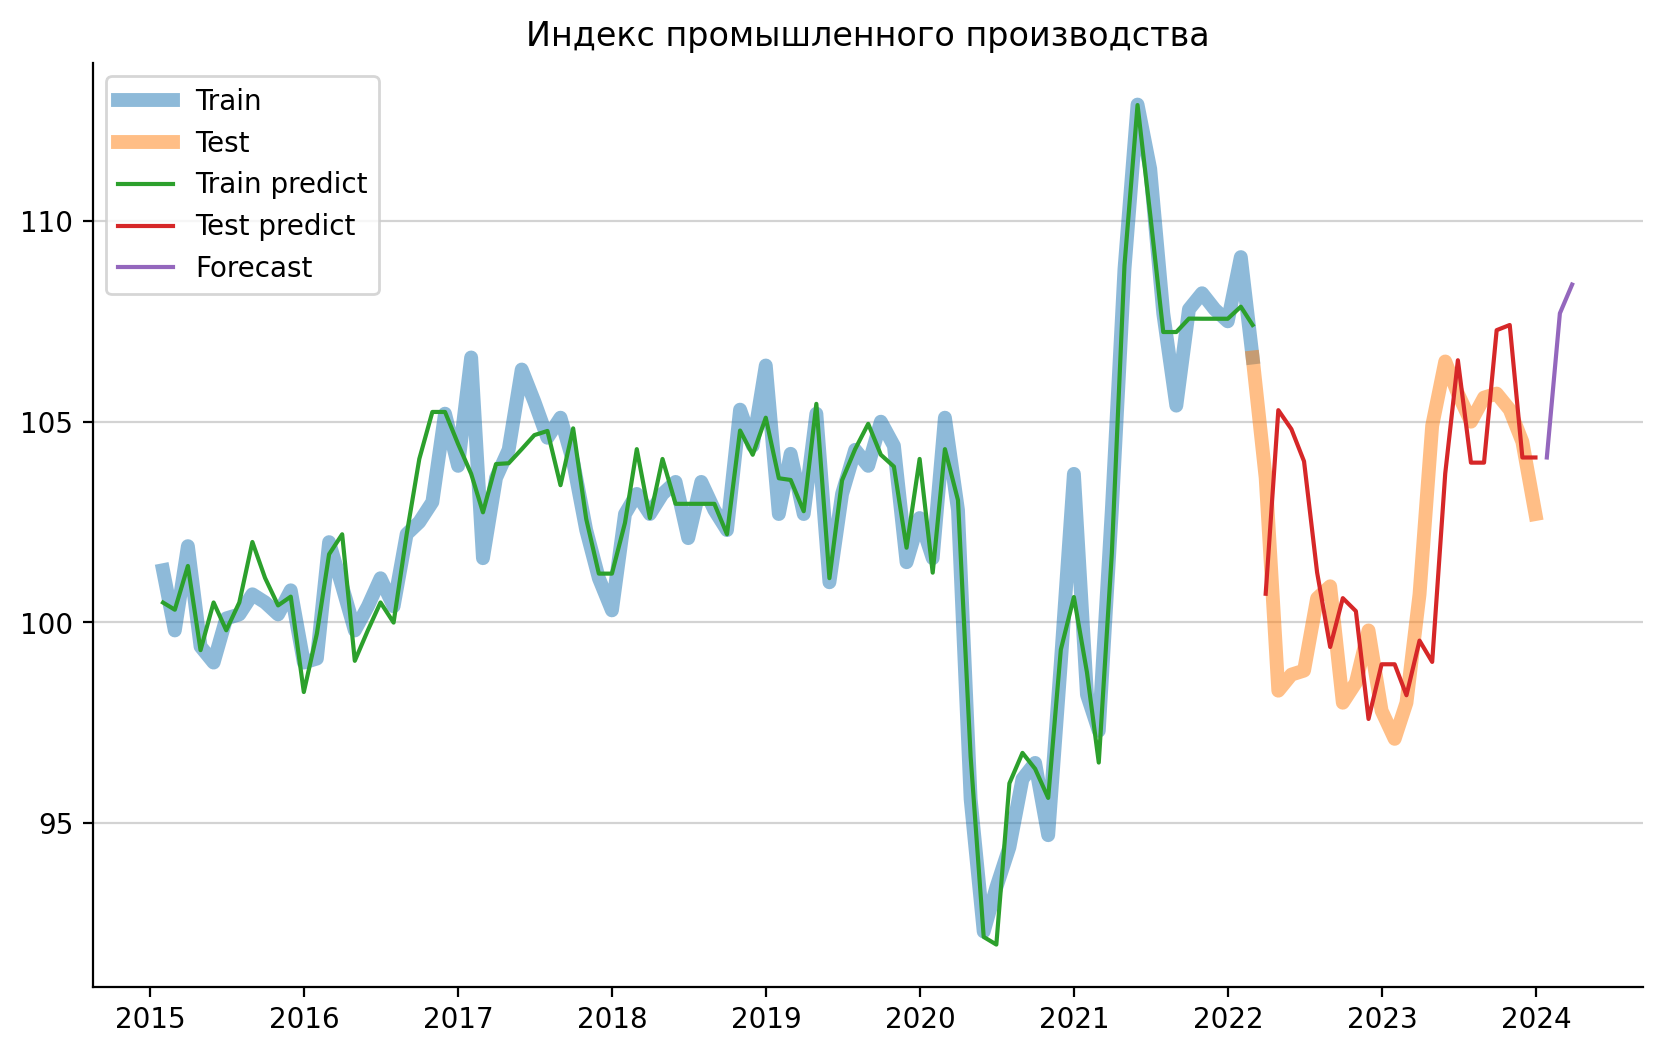

In [177]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# fig.text(y=.95, x=.125, s="Индекс промышленного производства",fontsize=16, fontweight="bold")
plt.title("Индекс промышленного производства",fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis='y', color='lightgrey')

ax.plot(df.date[:86], df['goal'][:86], label='Train', linewidth=5, alpha=0.5)
ax.plot(df.date[85:], df['goal'][85:], label='Test', linewidth=5, alpha=0.5)

ax.plot(df.date[:86], train_predict, label='Train predict')
ax.plot(df.date[86:], test_predict, label='Test predict')
ax.plot(forecast.date, forecast.goal_predict, label='Forecast')

ax.legend()
# ax.set_ylim([90, 115])
# ax.set_xlim([df.date.iloc[50], df.date.iloc[-1] + datetime.timedelta(days=31 * 6)])